## Library import & define Func 

In [8]:
import numpy as np
import pandas as pd

from requests import request, HTTPError
from requests.compat import urljoin, urlparse, quote, unquote
from time import sleep
import re
from urllib import parse
import os

from requests.sessions import Session
import warnings
warnings.filterwarnings('ignore')

import konlpy 
import nltk

konlpy.__version__, nltk.__version__

('0.5.2', '3.5')

In [14]:
def cleaning(data):
    data = re.sub(r'\b[a-z_][a-zA-Z_()]{4,}\b', '', data) ## 반드시 소문자+_ 1글자로 시작, 영문 4글자 이상인 패턴 삭제 ==>javascript부분 제거
    data = re.sub(r'\b[(){}/]{2,}','',data) ## 함수 기호 삭제 ==> () {} 제거
    data = re.sub(r'([.,?!])(\w)','\g<1> \g<2>', data) ## 구두점 다음에 글자가 있는 경우 공백 추가 ==> .단어 를 . 단어 로 변환 
    data = re.sub(r'\s{2,}', '\n', data) ## 공백 2개 이상인 경우 한개만 ==> \n\n\n\n\n ==> \n
    data = data.strip() ## 양쪽 공백 제거
    data = re.sub(r'[^\s\w\d.,?!:\'\"]', '', data) ## 공백 문자 숫자 구두점을 제외한 나머지 글자 삭제 (특수 문자 삭제)
    data = '\n'.join(data.splitlines()[1:]) ## 주석 삭제
    
    return data

In [15]:
corpus=[]

for file in os.listdir('./TXT'):
    with open('./TXT/'+file, 'rb') as f:
        corpus.append(cleaning(f.read().decode('utf-8', errors='ignore')))

In [16]:
data = ' '.join(corpus)

In [17]:
len(os.listdir('./TXT')), len(data), len(data.split()), len(set(data.split())) ## unique 

(112, 125503, 28929, 13026)

## N-gram

In [87]:
from collections import defaultdict

def ngram_umjeol(s, N=2): ## 2음절씩 끊어서 데이터 만들기
    rst = []
    for i in range(len(s)-(N-1)):
        rst.append(s[i:i+N])
    
    return rst

## 음절 수에 따라서 해당하는 단어 count 해주기

unigram = defaultdict(int)
for token in ngram_umjeol(data,1):
    unigram[token] += 1 

bigram = defaultdict(int)
for token in ngram_umjeol(data):
    bigram[token] += 1  
        
trigram = defaultdict(int)
for token in ngram_umjeol(data,3):
    trigram[token] += 1         

In [88]:
 sum(unigram.values()), len(unigram), sum(bigram.values()), len(bigram), sum(trigram.values()), len(trigram)

(125503, 1050, 125502, 14111, 125501, 38769)

- Language Model(Nl understanding ==> probabiliatice Model)
- MLE, MAP 빈도만
- P(A,B) ==> freq(Bigram)/freq(Unigram) ==> 1st MA

### bigram과 trigram을 활용해 단어의 빈도수를 통한 중요도 알아보기

In [89]:
start= '민주'

for _ in range(10):
    freq1 = bigram[start]
    maxfreq = 0.0
    for k in [i for i in trigram.keys() if i.startswith(start)]: ## start로 시작하는 2음절
        freq2 = trigram[k]
        prob = freq2 / freq1
        
        print(k, prob)
        print('='*30)    
    

민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125
민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125
민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125
민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125
민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125
민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125
민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125
민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125
민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125
민주주 0.025
민주노 0.4
민주당 0.5625
민주일 0.0125


## Konlpy ===> feature selection
- 굴적어 (어미의 활용이 다양)
- 어근, 어간, 형태소 + 어미
- 밥 을/도/() ...


===> nlp에서 자연어들을 feature로 삼기 위해서는 어떻한 방식으로 든지 token화를 진행하여야 한다..

In [57]:
from konlpy.tag import Kkma, Komoran, Hannanum, Okt

In [58]:
okt = Okt()

In [92]:
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [93]:
kkma = Kkma()
kkma.tagset

{'EC': '연결 어미',
 'ECD': '의존적 연결 어미',
 'ECE': '대등 연결 어미',
 'ECS': '보조적 연결 어미',
 'EF': '종결 어미',
 'EFA': '청유형 종결 어미',
 'EFI': '감탄형 종결 어미',
 'EFN': '평서형 종결 어미',
 'EFO': '명령형 종결 어미',
 'EFQ': '의문형 종결 어미',
 'EFR': '존칭형 종결 어미',
 'EP': '선어말 어미',
 'EPH': '존칭 선어말 어미',
 'EPP': '공손 선어말 어미',
 'EPT': '시제 선어말 어미',
 'ET': '전성 어미',
 'ETD': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JK': '조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKI': '호격 조사',
 'JKM': '부사격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JX': '보조사',
 'MA': '부사',
 'MAC': '접속 부사',
 'MAG': '일반 부사',
 'MD': '관형사',
 'MDN': '수 관형사',
 'MDT': '일반 관형사',
 'NN': '명사',
 'NNB': '일반 의존 명사',
 'NNG': '보통명사',
 'NNM': '단위 의존 명사',
 'NNP': '고유명사',
 'NP': '대명사',
 'NR': '수사',
 'OH': '한자',
 'OL': '외국어',
 'ON': '숫자',
 'SE': '줄임표',
 'SF': '마침표, 물음표, 느낌표',
 'SO': '붙임표(물결,숨김,빠짐)',
 'SP': '쉼표,가운뎃점,콜론,빗금',
 'SS': '따옴표,괄호표,줄표',
 'SW': '기타기호 (논리수학기호,화폐기호)',
 'UN': '명사추정범주',
 'VA': '형용사',
 'VC': '지정사',
 'VCN': "부정 지정사, 형용사 '아니다'",
 'VC

In [95]:
han = Hannanum()
kom = Komoran()

In [96]:
s = '아버지가방에들어가신다.' 

In [97]:
okt.pos(s)

[('아버지', 'Noun'),
 ('가방', 'Noun'),
 ('에', 'Josa'),
 ('들어가신다', 'Verb'),
 ('.', 'Punctuation')]

In [98]:
kkma.pos(s)

[('아버지', 'NNG'),
 ('가방', 'NNG'),
 ('에', 'JKM'),
 ('들어가', 'VV'),
 ('시', 'EPH'),
 ('ㄴ다', 'EFN'),
 ('.', 'SF')]

In [99]:
han.pos(s)

[('아버지가방에들어가', 'N'), ('이', 'J'), ('시ㄴ다', 'E'), ('.', 'S')]

In [100]:
kom.pos(s)

[('아버지', 'NNG'),
 ('가방', 'NNP'),
 ('에', 'JKB'),
 ('들어가', 'VV'),
 ('시', 'EP'),
 ('ㄴ다', 'EF'),
 ('.', 'SF')]

### text dataset 불러오기

In [31]:
from konlpy.corpus import kolaw, kobill ## text datastes

In [32]:
data =  kolaw.open(kolaw.fileids()[0]).read()

In [114]:
len(data), len(data.split()), len(set(data.split())) ## 데이터 개수, 어절 개수, 하나뿐인 어절 개수

(18884, 4178, 2029)

In [116]:
len(okt.morphs(data))

8796

In [117]:
len(set(okt.morphs(data))) ## unique한 어절들

1364

In [124]:
josa = [i for i in okt.pos(data) if i[1] =='Josa'] ## 조사  ## pos를 할경우 해당하는 품사를 함께 알려준다.

In [123]:
set(josa) 

{('가', 'Josa'),
 ('고', 'Josa'),
 ('과', 'Josa'),
 ('까지', 'Josa'),
 ('까지는', 'Josa'),
 ('까지로', 'Josa'),
 ('나', 'Josa'),
 ('는', 'Josa'),
 ('도', 'Josa'),
 ('든지', 'Josa'),
 ('로', 'Josa'),
 ('를', 'Josa'),
 ('마다', 'Josa'),
 ('며', 'Josa'),
 ('부터', 'Josa'),
 ('서', 'Josa'),
 ('에', 'Josa'),
 ('에게', 'Josa'),
 ('에게는', 'Josa'),
 ('에게만', 'Josa'),
 ('에는', 'Josa'),
 ('에도', 'Josa'),
 ('에서', 'Josa'),
 ('에서는', 'Josa'),
 ('에서의', 'Josa'),
 ('에의', 'Josa'),
 ('여', 'Josa'),
 ('와', 'Josa'),
 ('와의', 'Josa'),
 ('으로', 'Josa'),
 ('으로는', 'Josa'),
 ('으로부터', 'Josa'),
 ('으로서', 'Josa'),
 ('으로서의', 'Josa'),
 ('으로써', 'Josa'),
 ('은', 'Josa'),
 ('을', 'Josa'),
 ('의', 'Josa'),
 ('이', 'Josa'),
 ('이고', 'Josa'),
 ('이나', 'Josa'),
 ('이다', 'Josa'),
 ('이며', 'Josa'),
 ('인', 'Josa'),
 ('하고', 'Josa'),
 ('하고는', 'Josa'),
 ('한', 'Josa')}

- 담화 => 문단 => 문장 => 어절(구문) => 품사 => 형태소 => 토큰화
- 문장부터 tokenizing 필요하다

# nltk

### Tokenizing

In [140]:
nltk.download('gutenberg', 'punkt', 'stopwords')

True

In [151]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\park1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

### word tokenizing

In [19]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from nltk.tokenize import TreebankWordTokenizer

In [155]:
len(data.splitlines()),len(sent_tokenize(data))

(356, 357)

In [3]:
s = "Don't be fooled by the dark sounding name, Mr. Jone's Orphanage is as cheery as cheery goes for a pastry shop." 

In [5]:
word_tokenize(s)

['Do',
 "n't",
 'be',
 'fooled',
 'by',
 'the',
 'dark',
 'sounding',
 'name',
 ',',
 'Mr.',
 'Jone',
 "'s",
 'Orphanage',
 'is',
 'as',
 'cheery',
 'as',
 'cheery',
 'goes',
 'for',
 'a',
 'pastry',
 'shop',
 '.']

In [6]:
wordpunct_tokenize(s)

['Don',
 "'",
 't',
 'be',
 'fooled',
 'by',
 'the',
 'dark',
 'sounding',
 'name',
 ',',
 'Mr',
 '.',
 'Jone',
 "'",
 's',
 'Orphanage',
 'is',
 'as',
 'cheery',
 'as',
 'cheery',
 'goes',
 'for',
 'a',
 'pastry',
 'shop',
 '.']

In [7]:
text_to_word_sequence(s)

["don't",
 'be',
 'fooled',
 'by',
 'the',
 'dark',
 'sounding',
 'name',
 'mr',
 "jone's",
 'orphanage',
 'is',
 'as',
 'cheery',
 'as',
 'cheery',
 'goes',
 'for',
 'a',
 'pastry',
 'shop']

In [21]:
TreebankWordTokenizer().tokenize(s)

['Do',
 "n't",
 'be',
 'fooled',
 'by',
 'the',
 'dark',
 'sounding',
 'name',
 ',',
 'Mr.',
 'Jone',
 "'s",
 'Orphanage',
 'is',
 'as',
 'cheery',
 'as',
 'cheery',
 'goes',
 'for',
 'a',
 'pastry',
 'shop',
 '.']

In [61]:
data =  kolaw.open(kolaw.fileids()[0]).read()

In [60]:
len(set(data.split())), len(set(word_tokenize(data))), len(set(okt.morphs(data))), len(TreebankWordTokenizer().tokenize(data))

(2638, 2479, 1673, 11588)

### Sentence Tokenizing

In [22]:
from nltk.tokenize import sent_tokenize ## nltk 패키지에서 문장 token화를 위한 library

In [29]:
sent_tokenize("His barber kept his word. But keeping such a huge secret to himself was driving him crazy. Finally, the barber went up a mountain and almost to the edge of a cliff. He dug a hole in the midst of some reeds. He looked about, to make sure no one was near.")

['His barber kept his word.',
 'But keeping such a huge secret to himself was driving him crazy.',
 'Finally, the barber went up a mountain and almost to the edge of a cliff.',
 'He dug a hole in the midst of some reeds.',
 'He looked about, to make sure no one was near.']

In [23]:
! pip install kss

In [99]:
import kss ## 한국어 문장 tokenize를 위한 패키지

In [100]:
kss.split_sentences('딥 러닝 자연어 처리가 재미있기는 합니다. 그런데 문제는 영어보다 한국어로 할 때 너무 어려워요. 농담아니에요. 이제 해보면 알걸요?')

['딥 러닝 자연어 처리가 재미있기는 합니다.',
 '그런데 문제는 영어보다 한국어로 할 때 너무 어려워요.',
 '농담아니에요.',
 '이제 해보면 알걸요?']

In [39]:
sent_tokenize("유구한. 역사와. 전통에.빛나는 우리대한민국은.") ### . 구두점을 기준으로 문장을 분석한다(느낌,물음표, 공백, 마침표 등등)

['유구한.', '역사와.', '전통에.빛나는 우리대한민국은.']

In [55]:
from string import punctuation
punctuation ### 구두점

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [43]:
data = '\n'.join([kobill.open(corpus).read() for corpus in kobill.fileids()])

In [48]:
len(sent_tokenize(data)), len(data.splitlines()), len(kss.split_sentences(data))

(648, 4308, 300)

In [62]:
from nltk import Text

In [63]:
text = Text(okt.morphs(data))

In [72]:
text.vocab().most_common()[:10]

[('의', 380),
 ('.', 357),
 ('에', 282),
 ('을', 211),
 ('\n', 195),
 ('은', 179),
 ('제', 178),
 ('이', 176),
 ('한다', 155),
 ('·', 145)]

In [78]:
sum([ text.vocab().freq(i[0]) for i in text.vocab().most_common()[:10]]) ## 상위 10개의 단어들이 차지하는 비율 ===> 별 의미 없는 애들이 너무많은 비울을 차지한다  

0.25670759436107327

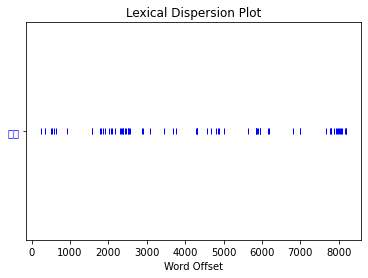

In [79]:
text.dispersion_plot(['국가']) ## 국가라는 단어의 사용 시점 plot으로 확인하기

In [91]:
text.similar('국가') 

국회 국무회의 국민 정부 헌법재판소 타인 국무총리 대한민국 법률 공무원 근로 대통령 조국 질서 각인 개정 그 정당 전통문화
인간


In [92]:
text.collocations()

의하지 아니하고는; 헌법재판소 재판관; 그러하지 아니하다; 인하여 불이익


In [93]:
corpus=[]

for file in os.listdir('./TXT'):
    with open('./TXT/'+file, 'rb') as f:
        corpus.append(cleaning(f.read().decode('utf-8', errors='ignore')))

In [94]:
data = ' '.join(corpus)

In [102]:
len(data.splitlines()), len(sent_tokenize(data)), len(kss.split_sentences(data))

(465, 1987, 508)

In [97]:
len(word_tokenize(data)), len(okt.morphs(data)), len(wordpunct_tokenize(data)), len(text_to_word_sequence(data))

(32886, 52947, 33254, 29202)

In [103]:
token1 = word_tokenize(data)
token2 = okt.morphs(data)

In [105]:
len(set(token1)), len(set(token2)) ## unique한 단어들의 개수 비교 ## 형태소 분석한 결과가 feature의 수가 적다

(12576, 7397)

In [109]:
Text(token2).vocab().most_common(10)

[('.', 2018),
 ('이', 1326),
 ('을', 1243),
 ('를', 886),
 ('의', 829),
 ('에', 802),
 (',', 720),
 ('가', 677),
 ('"', 635),
 ('는', 631)]

In [112]:
text = Text(token2)

In [115]:
sum([text.vocab().freq(i[0]) for i in text.vocab().most_common(100)]) ##  빈도수가 높은 별 의미없는 단어들의 비율이 매우 높다

0.4192494381173626

### n-gram 어절단위

In [149]:
def ngram_eojeol(token, n=2):
    #token = ['<sos>'] + token+['<eos>'] 
    rst=[]
    for i in range(len(token) - (n-1)):
        rst.append(' '.join(token[i:i+1]))
        
    return rst

In [150]:
from collections import defaultdict

In [151]:
unigram = defaultdict(lambda : 0)
bigram = defaultdict(lambda : 0)
trigram = defaultdict(lambda : 0)

In [152]:
for s in sent_tokenize(data):## data를 각각의 문장으로 쪼개기
    tokens = okt.morphs(s)
    
    for i in ngram_eojeol(['<sos>'] + tokens + ['<eos>'],1): ## unigram 만들기
        unigram[i] += 1
        
    for i in ngram_eojeol(['<sos>'] + tokens + ['<eos>'],2): ## bigram 만들기
        bigram[i] += 1
        
    for i in ngram_eojeol(['<sos>'] + tokens + ['<eos>'],3): ## trigram 만들기
        trigram[i] += 1 

In [153]:
len(unigram), len(bigram), len(trigram)

(7395, 7394, 7393)

In [154]:
s, e = '<sos>', '<eos>' ## 문장의 시작과 끝 미리 변수에 넣어두기

In [289]:
def predict(s = '<sos>', e = '<eos>'):
    #s, e = '<sos>', '<eos>' ## 문장의 시작과 끝 미리 변수에 넣어두기
    for _ in range(10):
        print(s)
        unigram[s]
        freq_list = {}
        
        for k in [filter(lambda keys: keys.split()[0] == s, bigram.keys())]:
            prob = bigram[k]/unigram[s]
            freq_list[k] = prob
        
        
        p = np.random.rand()
        sum_p = 0.0
        sorted_rst = sorted(freq_list.items(), key = lambda _:_[1], reverse=True)
        
        for _ in sorted_rst:
            sum_p += _[1]
            if sum_p >= p:
                next_key = _[0]
                break
        
        
        s = next_key.split()[-1]
        if s == e:
            break

- Tokenizing
- 문장, 단어 (어절 , 형태소 , 품사) , n-gram(NLU, NLG)

 ## Normalization
 - segmenting/ tokenizing words from running text
 - normalizing word formats
 - segmenting sentences in running text
 
 

In [302]:
from nltk.corpus import stopwords

In [307]:
stopword = stopwords.words('english')

In [310]:
stopword[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [305]:
len(stopwords.words('english'))

179

In [313]:
len(punctuation), punctuation

(32, '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [315]:
pattern = re.compile(r'[{}]'.format(re.escape(punctuation)))

In [319]:
clean=[]

for i in 'i like you'.split():
    if i in stopword:
        print(i, 'skip')
    else:
        clean.append(i)
        
clean

i skip
you skip


['like']

In [325]:
data = word_tokenize('i like you')

In [331]:
def remove_stopwords(tokenized_list): ## stopword 함수를 정희하여 제거해주기
    text = [word for word in tokenized_list if word not in stopword]
    return text
    
remove_stopwords(data)

['like']